In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import stats
from astropy.table import Table, Column
import matplotlib.colors as clr


import pandas as pd
from io import StringIO 
from astropy.io import ascii
import math
import random
from scipy.interpolate import griddata

import matplotlib.lines as mlines
import scipy
from scipy.stats import kde
from scipy.ndimage import gaussian_filter
from matplotlib.path import Path
import os

import matplotlib.image as mpimg
from astropy.wcs import WCS
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.optimize import curve_fit

from shapely.geometry import Polygon
import fitsio
from fitsio import FITS,FITSHDR

from gala.coordinates import MagellanicStreamNidever08
import gala.coordinates as gc
import astropy.coordinates as coord


from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

In [2]:
df2 = pd.read_csv('/Users/amymiller/sync_bm/research/vmc2/datafiles/wong/table5.txt',sep= '\s+',na_values=' ')


In [3]:
df2.columns

Index(['ID', 'ra', 'dec', 'VLSR', 'maj', 'min', 'PA', 'r', 'dr', 'dv', 'ddv',
       'LCO', 'dL', 'Mv', 'dM', 'Nvox', 'T', 'Iso', 'ID2'],
      dtype='object')

In [4]:
df = pd.read_csv('/Users/amymiller/sync_bm/research/vmc2/datafiles/wong/table5.csv',names=df2.columns)

In [5]:
#create molecular cloud for Wong 2011 molecular clouds
mcs={}
mcs['ra']=df['ra'].values
mcs['dec']=df['dec'].values

#convert major and minor axis from pc to degress. At distance of LMC 1 deg ~ 870 pc
mcs['maj']=np.array([i/871 for i in df['maj'].values])
mcs['min']=np.array([i/871 for i in df['min'].values])
mcs['pa']=np.array([float(i) for i in df['PA'].values])
mcs['r']=np.array([i/871 for i in df['r'].values])

mcs['r_pc'] = np.array([float(i) for i in df['r'].values])

mcs['mass'] = np.array([float(i) for i in df['Mv'].values])

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set DATE-END to '2010-11-10T08:04:24.776' from MJD-END'. [astropy.wcs.wcs]


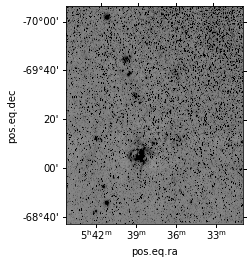

In [6]:

filename = get_pkg_data_filename('/Users/amymiller/sync_bm/research/vmc2/datafiles/e20191014_00130000215_dp_st_tl.fit')

hdu = fits.open(filename)[1]
wcs = WCS(hdu.header)
plt.figure()
ax=plt.subplot(projection=wcs)
ax.imshow(hdu.data,vmin=6450,vmax=6550,cmap='gray_r',origin='lower')


In [7]:
xmin,xmax,ymin,ymax = 12793,0,15683,0

ra2,dec2 = wcs.all_pix2world([xmin,xmax],[ymin,ymax],1)

In [8]:

def rotated_ellipse(x0,y0,a,b,pa,ff):
    
    #major axis is parallel to y axis
    #a is major radius in deg
    #b is minor radius in deg
    #x0,y0 are equaltorial central coord
    #pa is position angle north to east
    #ff is to be multplied to a,b to increase/decrease size

    rad = np.deg2rad(pa)
    
    #xx = [(((ff*b)/np.cos(np.deg2rad(y0)))*np.sin(i))*np.cos(rad) - (((2*a*np.cos(i)))/np.cos(np.deg2rad(y0)))*np.sin(rad) + x0 for i in np.linspace(0,2*np.pi,1000)]

    xx = [((ff*b)*np.sin(i))*np.cos(rad)/np.cos(np.deg2rad(y0)) - (((ff*a)*np.cos(i)))*np.sin(rad)/np.cos(np.deg2rad(y0)) + x0 for i in np.linspace(0,2*np.pi,1000)]
    
    yy = [((ff*b)*np.sin(i))*np.sin(rad) + ((ff*a)*np.cos(i))*np.cos(rad) + y0 for i in np.linspace(0,2*np.pi,1000)]
    
    
    return np.array(xx),np.array(yy)

In [9]:
def circle(rr,x0,y0):
    
    xx = [rr*np.cos(i)/np.cos(np.deg2rad(y0)) + x0 for i in np.linspace(0,2*np.pi,1000)]
    
    yy = [rr*np.sin(i) + y0 for i in np.linspace(0,2*np.pi,1000)]
    
    return np.array(xx),np.array(yy)

In [13]:
#create dictionary for ochsendorf 2017 molecular clouds
odf={}
omcs={}

In [14]:
for num in [4,6]:
    odf[num] = pd.read_csv('/Users/amymiller/sync_bm/research/vmc2/datafiles/ochsendorf2017/table'+str(num)+'.dat.txt', delimiter= '\s+', index_col=False)
    omcs[num]={}
    omcs[num]['ra']=odf[num]['ra'].values
    omcs[num]['dec']=odf[num]['dec'].values
    omcs[num]['r']=np.array([i/871 for i in odf[num]['radius'].values])
    omcs[num]['r_pc'] = np.array([float(i) for i in odf[num]['radius'].values])
    omcs[num]['mass'] = np.array([float(i) for i in odf[num]['mass'].values])

In [19]:
colors=['r','r','lime','cyan']

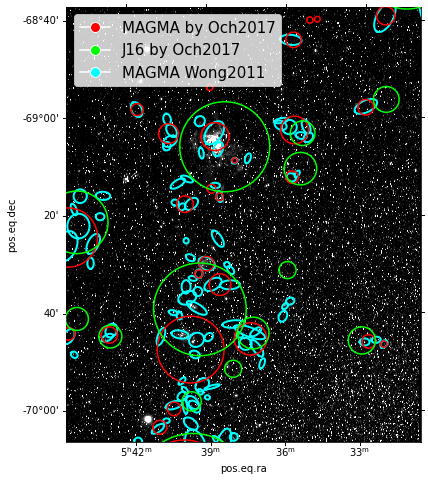

In [21]:
plt.figure(figsize=(8,8))
ax1=plt.subplot(projection=wcs)

ax1.imshow(hdu.data,vmin=6503,vmax=6650,cmap='gray',origin='lower')
ax1.set(xlim=(xmax, xmin), ylim=(ymin, ymax))

#plot wong ellipses
xxx,yyy = rotated_ellipse(mcs['ra'],mcs['dec'],mcs['maj'],mcs['min'],-mcs['pa'],1.91) 
pix_xxx,pix_yyy = wcs.all_world2pix(xxx,yyy,1)
ax1.plot(pix_xxx,pix_yyy,c='cyan',lw=2)

for num in [4,6]:
    xxx,yyy = circle(omcs[num]['r'],omcs[num]['ra'],omcs[num]['dec']) 
    xxx2,yyy2= wcs.all_world2pix(xxx,yyy,1)
    ax1.plot(xxx2,yyy2,c=colors[num-4],lw=1.5)

legend={}
legend[1] = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor='r', markersize=10, label='MAGMA by Och2017')
legend[2] = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor='lime', markersize=10, label='J16 by Och2017')
legend[3] = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor='cyan', markersize=10, label='MAGMA Wong2011')
ax1.legend(handles=[legend[key] for key in legend.keys()],fontsize=15,loc='best')    


comparing MAGMA adn J16. louds, one can see that J16 clouds are on avg larger and more massive and have lower internal densities. J16 has 1' sensitivity, MAGMA has 45''

now lets plot cummulative size dist for all these !!

In [22]:
def power_law(xx, a, b):
    return a*np.power(xx, b)

In [23]:
def linearfit(x,y):
    
    pars,cov = np.polyfit(np.log10(x),np.log10(y),1,cov=True)
    
    stdevs = np.sqrt(np.diag(cov))
    
    print('power law exponent is ',pars[0])
    print('error is ',stdevs[0])
    
    return pars[0],stdevs[0],(10**pars[1])

In [24]:
mass1 = mcs['mass'][~np.isnan(mcs['mass'])]

In [25]:
radius1 = mcs['r_pc'][~np.isnan(mcs['r_pc'])]

In [26]:
len(mass1)

422

In [27]:
len(radius1)

422

In [28]:
exp,error,coef = linearfit(radius1,mass1)

power law exponent is  1.7823115513653007
error is  0.07412018846835809


Text(0.5, 1.0, 'Wong 2011 molecular clouds')

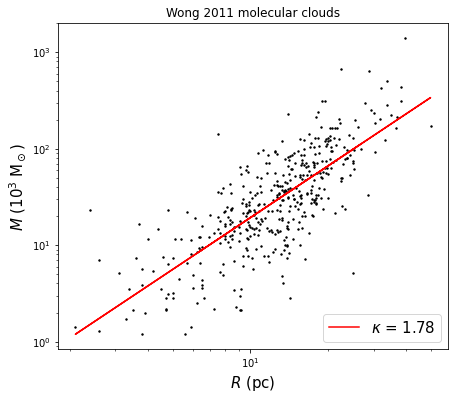

In [29]:
fig, ax = plt.subplots(figsize=(7,6))

ax.scatter(radius1,mass1,c='k',s=2)
ax.plot(radius1,power_law(radius1,coef,exp),'r')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.yscale('log')
plt.xscale('log')

one = mlines.Line2D([], [],color='r', markersize=10,label='$\kappa$ = '+str(np.round(exp,decimals=2)))

ax.legend(handles=[one],fontsize=15,loc='lower right')
ax.set_xlabel('$R$ (pc)',fontsize=15)
ax.set_ylabel('$M$ (10$^3$ M$_\odot$) ',fontsize=15)
ax.set_title('Wong 2011 molecular clouds')

In [30]:
def size1(radius,binsize,minn,maxx):
    
    #function to plot size distributions
    
    nums = np.arange(np.log10(minn), np.log10(maxx), binsize)
    tens = 10*np.ones(len(nums))
    binsr=np.power(tens,nums)
    
    n,bins,patches = plt.hist(radius,bins=binsr,edgecolor='k',color='w')
    plt.yscale('log')
    plt.xscale('log')
    
    r_centers = []

    for index in range(0,(len(bins)-1)):
    
        width = bins[index+1]-bins[index]
    
        center = bins[index+1]-(width/2)
    
        r_centers.append(center)
    r_centers=np.array(r_centers)
    
    maxindex, = np.where(n==max(n))
    
    for i in r_centers:
    
        print('%f' % (i))
    
    print('max index is ',n[maxindex])
    print('peak r value ',r_centers[maxindex])
    
    '''for i in r_centers:
    
        print('%f' % (i))'''
    
    return r_centers,n,maxindex,binsr
    

1.094251
1.300520
1.545671
1.837033
2.183318
2.594878
3.084019
3.665363
4.356292
5.177463
6.153426
7.313361
8.691946
10.330397
12.277699
14.592073
17.342711
20.611851
24.497231
29.115014
34.603259
41.126050
48.878402
58.092089
69.042578
82.057257
max index is  [71.]
peak r value  [14.59207312]


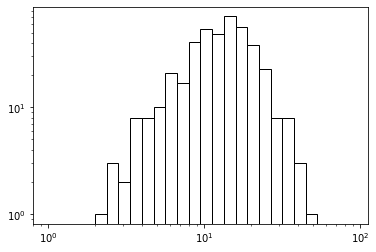

In [31]:
r_centersw,nw,maxindexw,binsrw = size1(radius1,0.075,1,10**2)

5.471256
6.502599
7.728354
9.185166
10.916590
12.974392
15.420093
18.326815
21.781461
25.887315
30.767131
36.566804
43.459728
51.651983
61.388497
72.960366
86.713557
103.059256
122.486155
145.575068
173.016293
max index is  [37.]
peak r value  [21.78146074]


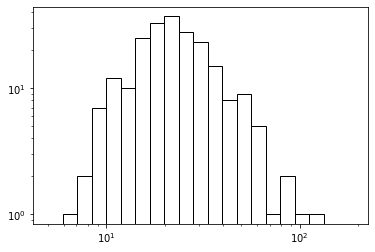

In [32]:
r_centerso,no,maxindexo,binsro = size1(omcs[4]['r_pc'],0.075,5,2*10**2)

10.942511
13.005199
15.456708
18.370332
21.833180
25.948783
30.840187
36.653630
43.562921
51.774629
61.534262
73.133608
86.919456
103.303967
122.776994
145.920731
173.427114
206.118511
244.972310
max index is  [19.]
peak r value  [43.56292148]


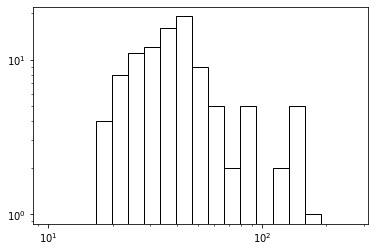

In [33]:
r_centerso2,no2,maxindexo2,binsro2 = size1(omcs[6]['r_pc'],0.075,10,3*10**2)

Text(0, 0.5, 'number frequency')

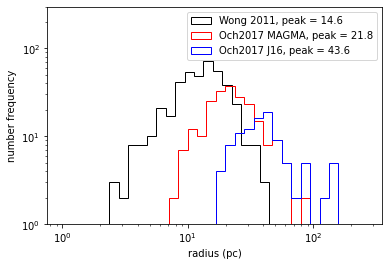

In [34]:
n,bins,patches = plt.hist(radius1,bins=binsrw,histtype=u'step',edgecolor='k',color='w',label='Wong 2011, peak = 14.6')
n,bins,patches = plt.hist(omcs[4]['r_pc'],bins=binsro,histtype=u'step',edgecolor='r',color='w',label='Och2017 MAGMA, peak = 21.8')
n,bins,patches = plt.hist(omcs[6]['r_pc'],bins=binsro2,histtype=u'step',edgecolor='b',color='w',label='Och2017 J16, peak = 43.6')

plt.legend(loc='best')

plt.yscale('log')
plt.xscale('log')
plt.ylim(1,300)
plt.xlabel('radius (pc)') 
plt.ylabel('number frequency')